In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, circuit, extensions
import matplotlib.pyplot as plt
import math
import numpy as np
from functools import reduce
import pandas as pd
from sklearn.model_selection import train_test_split
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
from datetime import datetime
from qiskit.aqua.components.optimizers import COBYLA, ADAM, AQGD, NFT

/home/mauk/.local/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


In [3]:
def normalize(l):
    normalization_factor = math.sqrt(sum([i ** 2 for i in l]))
    return [i / normalization_factor for i in l]

def init_gate(init_states, label=None, size=None):
    if not size:
        size = math.ceil(math.log2(len(init_states)))
    state_vector = normalize(init_states) + [0] * ((2 ** size) - len(init_states))
    #I know this is way ugly, but it's the easiest way to actualy turn initialize() into a gate
    return extensions.Initialize(state_vector).gates_to_uncompute().inverse().to_gate(label=label if label else None)

In [4]:
def x_indices(i, bits):
    indices = []
    for j in range(bits):
        bit = (i >> j) & 1
        if not bit:
            indices.append(j)
    return indices

In [5]:
def construct_oracle(data, labels):
    # gate = init_gate([0,2,10], "psi_0")
    data_bits = math.ceil(math.log2(data.shape[1]))
    counting_bits = math.ceil(math.log2(data.shape[0]))
#     print(len(data), data.shape[0])
    q = QuantumRegister(data_bits + counting_bits + 1)
    qc = QuantumCircuit(q)

#     data = [[x,x*2,x**2] for x in range(1, 16)]
    qc.h(q[data_bits + 1:])
    for i in range(len(data)):
        x_i = [data_bits + 1 + x_i for x_i in x_indices(i,counting_bits)]
        if len(x_i) > 0:
            qc.x(x_i)
        gate = init_gate(data[i], f"psi_{i}", data_bits).control(counting_bits)
        qc.append(gate, q[data_bits + 1:] + q[:data_bits])
        if labels[i] == 1:
            x_gate = circuit.library.XGate().control(counting_bits)
            qc.append(x_gate, q[data_bits + 1:] + [q[data_bits]])

        if len(x_i) > 0:
            qc.x(x_i)
    return qc, data_bits, counting_bits

In [6]:
def destructive_swap(n):
    q = QuantumRegister(n * 2)
    circuit = QuantumCircuit(q)
    
    for i in range(n):
        circuit.cx(i, n+i)
        circuit.h(i)
#     print(circuit)
    return circuit.to_gate(label="destructive_swap")


In [7]:
def interpret_des_swap(counts):
    successes = 0
    for k in counts:
        #success if and of measurement has even parity, that's what the paper said
        success = reduce(lambda b, p: (p == ('1', '1')) ^ b , zip(list(k[:len(k)//2]), list(k[len(k)//2:])), True)
#         print(k, success)
#         success = k.count('1') % 2 == 0
        if success:
            successes += counts[k]
    if sum(counts.values()) == 0:
        return 0
    return  2 * (successes / sum(counts.values())) - 1

In [8]:
def construct_classifier(data, labels):
    input_size = math.ceil(math.log2(data.shape[1]))
    oracle, data_bits, counting_bits = construct_oracle(data, labels)
#     print(oracle)
    oracle = oracle.to_gate(label="oracle")
    q = QuantumRegister(input_size + data_bits + counting_bits + 1)
    c = ClassicalRegister(input_size * 2 + 1)
    qc = QuantumCircuit(q, c)
    
    qc.append(oracle, q[input_size:])
#     print(input_size)
    qc.append(destructive_swap(input_size), q[:input_size] + q[input_size:input_size+input_size])
    for i in range(input_size * 2 + 1):
        qc.measure(i,i)
    return qc


In [9]:
df = pd.read_csv("bezdekIris.data", header=None)

In [10]:
df[4] = [0 if p == "Iris-setosa" else 1 if p == "Iris-virginica" else 2 for p in df[4]]
df = df[df[4] != 2]

In [26]:
# TODO: Normalize data?

train, test = train_test_split(df, test_size=0.36)
data = train[[0,1]].to_numpy()
labels = train[4].to_numpy()

n_data_points = 2

n_label0s = n_data_points / 2
n_label1s = n_data_points / 2

label0s = []
label1s = []

for i in range(len(labels)):
    if labels[i] == 0 and n_label0s > 0:
        n_label0s -= 1
        label0s.append(i)
        
    if labels[i] == 1 and n_label1s > 0:
        n_label1s -= 1
        label1s.append(i)
        
    if n_label0s < 1 and n_label1s < 1:
        break

idx = label0s + label1s
        
data = data[idx]
labels = labels[idx]

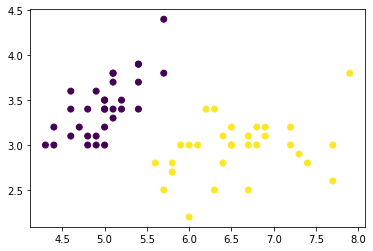

In [12]:
plt.scatter(x=data[:, 0], y=data[:, 1], c=labels)
plt.show()

/home/mauk/.local/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


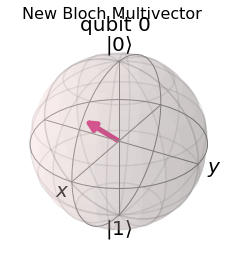

In [13]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

inp_gate = init_gate([6.5, 3], label="input", size=1)

qc.append(inp_gate, q[0:1])

state = Statevector.from_instruction(qc)
plot_bloch_multivector(state, title="New Bloch Multivector", reverse_bits=False)

/home/mauk/.local/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


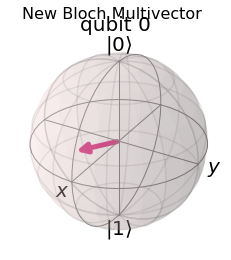

In [14]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

inp_gate = init_gate([5, 3.5], label="input", size=1)

qc.append(inp_gate, q[0:1])

state = Statevector.from_instruction(qc)
plot_bloch_multivector(state, title="New Bloch Multivector", reverse_bits=False)

In [15]:
# data = np.ones((20,4))
# data = np.array([np.array([1,2,0,4]) for i in range(20)])


qc_classifier = construct_classifier(data, labels)


In [16]:
def classify(inp):
    num_qubits = qc_classifier.num_qubits

    data_size = math.ceil(math.log2(data.shape[1]))

    num_cbits = data_size * 2 + 1


    q = QuantumRegister(num_qubits)
    c = ClassicalRegister(num_cbits)
    qc = QuantumCircuit(q, c)

    # inp_gate = init_gate([1,2,0,4])
    inp_gate = init_gate(inp, label="input", size=data_size)


    qc.append(inp_gate, q[0:1])
    qc = qc.compose(qc_classifier)
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=qc, shots=500)
    result = job.result()

    counts = result.get_counts()
    counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
    counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

    return (interpret_des_swap(counts_0), interpret_des_swap(counts_1))

In [17]:
# labels = [0,1]
# correct = 0
# count = 0
# for index, row in test.iterrows():
#     label = row[4]
#     results = classify(row[[0,1]].tolist())
#     cor = False
#     if results[0] > results[1] and label == labels[0]:
#         correct += 1
#         cor = True
#     elif results[0] < results[1] and label == labels[1]:
#         correct += 1
#         cor = True
#     count += 1
#     print(f"features:({row[0]}, {row[1]}), label:{label}, result:{labels[0]}:{results[0]}, {labels[1]}:{results[1]}, {'correct' if cor else 'incorrect'}, accuracy:{correct / count}")

# print(correct / len(test))


In [18]:
num_qubits = qc_classifier.num_qubits

data_size = math.ceil(math.log2(data.shape[1]))

num_cbits = data_size * 2 + 1

q = QuantumRegister(num_qubits)
c = ClassicalRegister(num_cbits)
qc = QuantumCircuit(q, c)

# inp_gate = init_gate([1,2,0,4])
inp_gate = init_gate([1,2], label="input", size=data_size)

qc.append(inp_gate, q[0:1])
qc = qc.compose(qc_classifier)
print(qc)
backend = Aer.get_backend('qasm_simulator')
job = execute(backend=backend, experiments=qc, shots=2000)
result = job.result()

# print(result.get_counts())
counts = result.get_counts()

counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

print(counts)
print(interpret_des_swap(counts_0))
print(interpret_des_swap(counts_1))

         ┌───────┐ ┌───────────────────┐┌─┐   
q135_0: ─┤ input ├─┤0                  ├┤M├───
        ┌┴───────┴┐│  destructive_swap │└╥┘┌─┐
q135_1: ┤0        ├┤1                  ├─╫─┤M├
        │         │└────────┬─┬────────┘ ║ └╥┘
q135_2: ┤1        ├─────────┤M├──────────╫──╫─
        │         │         └╥┘          ║  ║ 
q135_3: ┤2        ├──────────╫───────────╫──╫─
        │         │          ║           ║  ║ 
q135_4: ┤3        ├──────────╫───────────╫──╫─
        │  oracle │          ║           ║  ║ 
q135_5: ┤4        ├──────────╫───────────╫──╫─
        │         │          ║           ║  ║ 
q135_6: ┤5        ├──────────╫───────────╫──╫─
        │         │          ║           ║  ║ 
q135_7: ┤6        ├──────────╫───────────╫──╫─
        │         │          ║           ║  ║ 
q135_8: ┤7        ├──────────╫───────────╫──╫─
        └─────────┘          ║           ║  ║ 
  c3: 3/═════════════════════╩═══════════╩══╩═
                             2           0  1 


KeyboardInterrupt: 

In [22]:
# n_features gets boiled down to amount of qubits necessary for it to work TODO: Change n_labels to do the same
def build_variational_circuit(depth, n_features, n_labels, params=None, measurement=False):
    # TODO: Add y and z rotations
    n_qubits = math.ceil(math.log2(n_features)) + n_labels
    
    def seriessum(n):
        n_sum = 0
        for i in range(n):
            n_sum += i
        return n_sum
    
    n_rot_qubits_per_layer = n_qubits * 2
    n_qubits_per_layer = n_rot_qubits_per_layer #+ seriessum(n_qubits)
    n_entangle_qubits_per_layer = 0 #seriessum(n_qubits)
    
#     print(params)
    
    if params is None:
        params = np.random.rand(depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)) * math.pi
    
#     print(params)
    
#     print(len(params))
    
    q = QuantumRegister(n_qubits)
    if measurement:
        c = ClassicalRegister(n_qubits)
        qc = QuantumCircuit(q, c)
    else:
        qc = QuantumCircuit(q)
        
    
    # Dynamically add rx rotation and rxx entanglement gates
    for i in range(depth):
        for j in range(n_qubits):
#             print(i * depth, j)
#             print(i * n_qubits_per_layer, j, (i * n_qubits_per_layer) + j)
            qc.rx(params[i * n_qubits_per_layer + j*2], j)
            qc.rz(params[i * n_qubits_per_layer + j*2 + 1], j)
        next_param = 0
        for j in range(n_qubits):
#             print(i * n_qubits_per_layer, j, (i * n_qubits_per_layer) + j)
            for k in range(n_qubits):
                if j == k or j < k:
                    continue
#                 print(i * n_qubits_per_layer + n_rot_qubits_per_layer + next_param)
#                 print(i * n_rot_qubits_per_layer + j + next_param + n_rot_qubits_per_layer)
                qc.cx(j, k)
        
        if measurement:
            qc.barrier()
    
    if measurement:
        for i in range(n_qubits):
            qc.measure(i, i)
            
    return qc
      
build_variational_circuit(3, 8, 1, measurement=True).draw()

┌────────────┐┌─────────────┐┌───┐┌───┐     ┌───┐           ░ »
q169_0: ┤ Rx(2.5411) ├┤ Rz(0.88617) ├┤ X ├┤ X ├─────┤ X ├───────────░─»
        ├────────────┤└┬────────────┤└─┬─┘└─┬─┘┌───┐└─┬─┘┌───┐      ░ »
q169_1: ┤ Rx(2.7084) ├─┤ Rz(1.0428) ├──■────┼──┤ X ├──┼──┤ X ├──────░─»
        ├────────────┤ ├────────────┤       │  └─┬─┘  │  └─┬─┘┌───┐ ░ »
q169_2: ┤ Rx(2.5951) ├─┤ Rz(1.9999) ├───────■────■────┼────┼──┤ X ├─░─»
        ├────────────┤ ├────────────┤                 │    │  └─┬─┘ ░ »
q169_3: ┤ Rx(3.0454) ├─┤ Rz(1.0858) ├─────────────────■────■────■───░─»
        └────────────┘ └────────────┘                               ░ »
  c7: 4/══════════════════════════════════════════════════════════════»
                                                                      »
«         ┌────────────┐┌────────────┐┌───┐┌───┐     ┌───┐           ░ »
«q169_0: ─┤ Rx(2.5711) ├┤ Rz(1.1453) ├┤ X ├┤ X ├─────┤ X ├───────────░─»
«         ├────────────┤├────────────┤└─┬─┘└─┬─┘┌───┐└─┬─┘┌───┐      ░ »
«q169_1: ─┤ Rx(2.6144) ├┤ Rz(2.1769) ├──■────┼──┤ X ├──┼──┤ X ├──────░─»
«         ├────────────┤├────────────┤       │  └─┬─┘  │  └─┬─┘┌───┐ ░ »
«q169_2: ─┤ Rx(1.4505) ├┤ Rz(3.0634) ├───────■────■────┼────┼──┤ X ├─░─»
«        ┌┴────────────┤├────────────┤                 │    │  └─┬─┘ ░ »
«q169_3: ┤ Rx(0.31913) ├┤ Rz(1.3499) ├─────────────────■────■────■───░─»
«        └─────────────┘└────────────┘                               ░ »
«  c7: 4/══════════════════════════════════════════════════════════════»
«                                                                      »
«        ┌─────────────┐┌─────────────┐┌───┐┌───┐     ┌───┐           ░ ┌─┐   »
«q169_0: ┤ Rx(0.79153) ├┤ Rz(0.58578) ├┤ X ├┤ X ├─────┤ X ├───────────░─┤M├───»
«        └┬────────────┤└┬────────────┤└─┬─┘└─┬─┘┌───┐└─┬─┘┌───┐      ░ └╥┘┌─┐»
«q169_1: ─┤ Rx(2.6978) ├─┤ Rz(2.8982) ├──■────┼──┤ X ├──┼──┤ X ├──────░──╫─┤M├»
«         ├────────────┤ ├────────────┤       │  └─┬─┘  │  └─┬─┘┌───┐ ░  ║ └╥┘»
«q169_2: ─┤ Rx(1.2876) ├─┤ Rz(2.0234) ├───────■────■────┼────┼──┤ X ├─░──╫──╫─»
«        ┌┴────────────┤┌┴────────────┤                 │    │  └─┬─┘ ░  ║  ║ »
«q169_3: ┤ Rx(0.45288) ├┤ Rz(0.48367) ├─────────────────■────■────■───░──╫──╫─»
«        └─────────────┘└─────────────┘                               ░  ║  ║ »
«  c7: 4/════════════════════════════════════════════════════════════════╩══╩═»
«                                                                        0  1 »
«              
«q169_0: ──────
«              
«q169_1: ──────
«        ┌─┐   
«q169_2: ┤M├───
«        └╥┘┌─┐
«q169_3: ─╫─┤M├
«         ║ └╥┘
«  c7: 4/═╩══╩═
«         2  3

In [27]:
def construct_generator_classifier(depth, n_features, n_labels, inp, params):
#     print(data.shape)
    input_size = math.ceil(math.log2(data.shape[1]))
#     oracle, data_bits, counting_bits = construct_oracle(data, labels)
    variational_oracle = build_variational_circuit(depth, n_features, n_labels, params)
    variational_oracle_gate = variational_oracle.to_gate(label="variational_oracle")
    q = QuantumRegister(input_size + variational_oracle.num_qubits + 1)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q, c)
#     print(input_size)

    inp_gate = init_gate(inp, label="input", size=input_size)
    
    swap_test_ancilla = q[0:1]
    inp_qubits = q[1:input_size + 1]
    oracle_data_qubits = q[input_size + 1:input_size * 2 + 1]
    label_qubit = q[input_size * 2 + 1:input_size * 2 + 2]
    extra_oracle_qubits = q[input_size * 2 + 2:]
    
#     print("swap_test_ancilla", len(swap_test_ancilla))
#     print("inp_qubits", len(inp_qubits))
#     print("oracle_data_qubits", len(oracle_data_qubits))
#     print("label_qubit", len(label_qubit))
#     print(variational_oracle)

    qc.append(inp_gate, inp_qubits)
    qc.append(variational_oracle_gate, oracle_data_qubits + label_qubit + extra_oracle_qubits)
    qc.append(swap(input_size), swap_test_ancilla + inp_qubits + oracle_data_qubits)
    qc.measure(swap_test_ancilla, 0)
    qc.measure(label_qubit, 1)

    return qc

# params = [1, 1, 1, 1, 1, 1, 1, 1, 1]
# construct_generator_classifier([1, 2], params).draw()

In [28]:
def swap(n):
    q = QuantumRegister(n * 2 + 1)
    circuit = QuantumCircuit(q)
    circuit.h(q[0])
    
    for i in range(0, n):
        circuit.cswap(0, 1 + i, 1 + n+i)
    circuit.h(q[0])
    return circuit.to_gate(label="swap")

In [29]:
def build_gan_stack(depth, n_features, n_labels, params=None):
    oracle, n_data_qubits, n_counting_qubits = construct_oracle(data, labels)
    generator = build_variational_circuit(depth, n_features, n_labels, params=params)
    
    oracle_gate = oracle.to_gate(label="oracle")
    generator_gate = generator.to_gate(label="generator")
    
    n_qubits = n_counting_qubits + n_data_qubits + generator.num_qubits + 2
    
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    swap_ancilla = q[:1]
    generator_qubits = q[1:generator.num_qubits + 1]
    generator_output_qubits = q[1:1 + n_data_qubits + 1]
    oracle_qubits = q[generator.num_qubits + 1:]
    oracle_output_qubits = q[generator.num_qubits + 1: generator.num_qubits + 1 + n_data_qubits]
    oracle_label_qubits = q[generator.num_qubits + 1 + n_data_qubits:generator.num_qubits + 1 + n_data_qubits + 1]

    oracle_counting_qubits = q[generator.num_qubits + 1 + n_data_qubits + 1:]
    
    qc.append(generator_gate, generator_qubits)
    qc.append(oracle_gate, oracle_qubits)
    
    swap_test_gate = swap(n_data_qubits + 1)
    swap_test_qubits = swap_ancilla + generator_output_qubits + oracle_output_qubits + oracle_label_qubits
#     print(len(generator_output_qubits), len(oracle_output_qubits), len(oracle_label_qubits))
    
    qc.append(swap_test_gate, swap_test_qubits)
    
    qc.measure(0, 0)
    
    return qc

build_gan_stack(8, 8, 1).draw()

┌───────┐┌─┐
q306_0: ──────────────┤0      ├┤M├
        ┌────────────┐│       │└╥┘
q306_1: ┤0           ├┤1      ├─╫─
        │            ││       │ ║ 
q306_2: ┤1           ├┤2      ├─╫─
        │  generator ││       │ ║ 
q306_3: ┤2           ├┤  swap ├─╫─
        │            ││       │ ║ 
q306_4: ┤3           ├┤       ├─╫─
        └┬─────────┬─┘│       │ ║ 
q306_5: ─┤0        ├──┤3      ├─╫─
         │         │  │       │ ║ 
q306_6: ─┤1 oracle ├──┤4      ├─╫─
         │         │  └───────┘ ║ 
q306_7: ─┤2        ├────────────╫─
         └─────────┘            ║ 
  c9: 1/════════════════════════╩═
                                0

In [30]:
gan_stack_qc = build_gan_stack(3, 8, 1)

In [31]:
def get_generator_similarity(gan_stack_qc):
    start = datetime.now()
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=gan_stack_qc, shots=200)
    result = job.result()

    counts = result.get_counts()
    return counts
#     print(counts)
#     print(datetime.now() - start)

In [32]:
def classify_variationally(depth, n_features, n_labels, params, data_point):
    variational_classifier = construct_generator_classifier(depth, n_features, n_labels, data_point, params)

    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=variational_classifier, shots=1500)
    result = job.result()

    counts = result.get_counts()
    counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
    counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

    return (interpret_des_swap(counts_0), interpret_des_swap(counts_1))

# data_point = [5, 3.5]
# params = [1, 1, 1, 1, 1, 1, 1, 1, 1]
# classify_variationally(params, data_point)

In [33]:
label_names = [0,1]
params = None# [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
correct = 0
count = 0
for index, row in test.iterrows():
    label = row[4]
    results = classify_variationally(8, 2, 1, params, row[[0,1]].tolist())
    cor = False
    if results[0] > results[1] and label == label_names[0]:
        correct += 1
        cor = True
    elif results[0] < results[1] and label == label_names[1]:
        correct += 1
        cor = True
    count += 1
    print(f"features:({row[0]}, {row[1]}), label:{label}, result:{label_names[0]}:{results[0]}, {label_names[1]}:{results[1]}, {'correct' if cor else 'incorrect'}, accuracy:{correct / count}")

print(correct / len(test))

features:(6.4, 3.1), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.7, 2.5), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.3, 3.4), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.4, 2.8), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(7.2, 3.0), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(5.1, 3.5), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.4, 2.7), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.3, 2.7), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(5.8, 4.0), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(4.9, 3.1), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.9, 3.1), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(5.7, 4.4), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.7, 3.3), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0

Initial parameters: [0.79414846 2.24327918 1.08588153 0.75458074 1.47319253 1.95618111
 1.17019399 1.21353439 2.24461388 1.7074365  1.31099726 1.07925639
 0.67119831 2.39134623 2.08001694 0.8718339  3.14118008 1.44802285
 0.36592679 2.66911729 0.29346706 0.08978826 1.79131619 2.52188148
 1.53618385 2.24028553 3.04035645 1.31243    2.27225494 2.93967371
 2.0034406  0.1610966  1.33065468 1.79166959 1.06237539 1.71489927
 1.38315735 2.69840302 0.58955401 3.07155365 0.5820593  2.77531117
 2.73902006 2.29031302 1.76774086 0.6591184  2.45938421 1.03841743
 0.31633157 1.96827142 0.19275949 1.67658658 2.70112667 1.89167393
 1.76364804 2.91887579 2.54283495 0.60086339 0.40717349 0.5312811
 2.196022   0.44642911 2.76254316 2.10629997 0.29395166 2.36451053
 1.62218649 2.1201034  2.73408497 1.68200638 2.43403307 0.19449251
 1.66097723 2.3995214  2.26595918 2.1459871  0.85028627 0.15049207
 1.63596263 0.36314261 0.8780364  2.74312652 1.35839076 1.79394933
 0.20923945 1.85133626 1.00423861 0.5146481

/home/mauk/.local/lib/python3.8/site-packages/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.components.optimizers',


2 opt -0.3480000000000001 cur -0.3480000000000001
3 opt -0.3480000000000001 cur -0.20399999999999996
4 opt -0.3480000000000001 cur -0.236
5 opt -0.3480000000000001 cur -0.28800000000000003
6 opt -0.3480000000000001 cur -0.256
7 opt -0.3480000000000001 cur -0.276
8 opt -0.3480000000000001 cur -0.32400000000000007
9 opt -0.3480000000000001 cur -0.256
10 opt -0.3480000000000001 cur -0.21199999999999997
11 opt -0.3480000000000001 cur -0.18799999999999994
12 opt -0.3480000000000001 cur -0.24
13 opt -0.3480000000000001 cur -0.19199999999999995
14 opt -0.3480000000000001 cur -0.17199999999999993
15 opt -0.3480000000000001 cur -0.31200000000000006
16 opt -0.3480000000000001 cur -0.32800000000000007
17 opt -0.3480000000000001 cur -0.21199999999999997
18 opt -0.3480000000000001 cur -0.17599999999999993
19 opt -0.3480000000000001 cur -0.252
20 opt -0.3480000000000001 cur -0.26
21 opt -0.3480000000000001 cur -0.244
22 opt -0.3600000000000001 cur -0.3600000000000001
23 opt -0.3600000000000001 cur -

193 opt -0.536 cur -0.43999999999999995
194 opt -0.536 cur -0.3640000000000001
195 opt -0.536 cur -0.3839999999999999
196 opt -0.536 cur -0.3879999999999999
197 opt -0.536 cur -0.44799999999999995
198 opt -0.536 cur -0.3560000000000001
199 opt -0.536 cur -0.46399999999999997
200 opt -0.536 cur -0.45199999999999996
201 opt -0.536 cur -0.42799999999999994
202 opt -0.536 cur -0.45999999999999996
203 opt -0.536 cur -0.5
204 opt -0.536 cur -0.3999999999999999
205 opt -0.536 cur -0.45599999999999996
206 opt -0.536 cur -0.3640000000000001
207 opt -0.536 cur -0.42399999999999993
208 opt -0.536 cur -0.3480000000000001
209 opt -0.536 cur -0.46399999999999997
210 opt -0.536 cur -0.44799999999999995
211 opt -0.536 cur -0.45199999999999996
212 opt -0.536 cur -0.43199999999999994
213 opt -0.536 cur -0.512
214 opt -0.536 cur -0.3959999999999999
215 opt -0.536 cur -0.45599999999999996
216 opt -0.536 cur -0.4119999999999999
217 opt -0.536 cur -0.44399999999999995
218 opt -0.536 cur -0.45999999999999996

367 opt -0.5680000000000001 cur -0.42799999999999994
368 opt -0.5680000000000001 cur -0.3720000000000001
369 opt -0.5680000000000001 cur -0.44799999999999995
370 opt -0.5680000000000001 cur -0.3919999999999999
371 opt -0.5680000000000001 cur -0.3999999999999999
372 opt -0.5680000000000001 cur -0.3919999999999999
373 opt -0.5680000000000001 cur -0.43999999999999995
374 opt -0.5680000000000001 cur -0.44399999999999995
375 opt -0.5680000000000001 cur -0.52
376 opt -0.5680000000000001 cur -0.44799999999999995
377 opt -0.5680000000000001 cur -0.43199999999999994
378 opt -0.5680000000000001 cur -0.46799999999999997
379 opt -0.5680000000000001 cur -0.3879999999999999
380 opt -0.5680000000000001 cur -0.43199999999999994
381 opt -0.5680000000000001 cur -0.3520000000000001
382 opt -0.5680000000000001 cur -0.3999999999999999
383 opt -0.5680000000000001 cur -0.41999999999999993
384 opt -0.5680000000000001 cur -0.3720000000000001
385 opt -0.5680000000000001 cur -0.48
386 opt -0.5680000000000001 cur

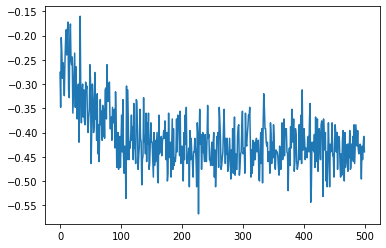

Supposed optimal parameters: [ 1.73996809e+00  2.44097800e+00  1.28113898e+00  8.61755977e-01
  1.54393615e+00  1.63734543e+00  1.29530424e+00  1.28427801e+00
  2.42810625e+00  1.50635833e+00  1.51543204e+00  1.25889291e+00
  8.48007471e-01  2.51047814e+00  2.20711996e+00  1.06676967e+00
  3.64020405e+00  2.23455001e+00  7.35759409e-01  3.57680296e+00
  1.43651231e+00  4.52963525e-02  1.74747507e+00  2.46163270e+00
  1.48458849e+00  2.19245885e+00  3.06187626e+00  2.31840834e+00
  2.24435604e+00  2.91140654e+00  3.02735394e+00  1.17255484e-01
  1.20112410e+00  1.74185014e+00  1.04244760e+00  1.66308703e+00
  1.32337400e+00  2.67249690e+00  5.35749003e-01  3.04963309e+00
  5.64124294e-01  2.71353505e+00  2.68521505e+00  2.23252246e+00
  1.74382752e+00  6.49154505e-01  2.43347809e+00  1.00454021e+00
  2.36620441e-01  1.90649530e+00  1.21468005e+00  1.64071657e+00
  2.61942277e+00  1.82591225e+00  1.73176359e+00  2.87902022e+00
  2.44917438e+00  5.55029490e-01  3.41411808e-01  5.07367764e

In [34]:
# Define variational circuit_variables
circuit_depth = 10
n_features = 4
n_labels = 1

intermediate_results = []

global optimal_params
optimal_params = []
global optimal_cost
optimal_cost = 0
global i
i = 0

def objective_function(params):
    global i
    global optimal_cost
    global optimal_params
    
    i += 1
    
    # construct circuit with given params
    qc = build_gan_stack(circuit_depth, n_features, n_labels, params)
    
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=qc, shots=500)
    counts = job.result().get_counts()
    
    result = 2 * counts['0'] / sum(counts.values()) - 1
    
    result = -result
    
    intermediate_results.append(result)
    
    if result < optimal_cost:
        optimal_cost = result
        optimal_params = params
#         print(params)
        
    print(i, "opt", optimal_cost, "cur", result)
    
    return result
    
def generate_params(circuit_depth, n_features, n_labels):
    
    n_qubits = math.ceil(math.log2(n_features)) + n_labels

    def seriessum(n):
        n_sum = 0
        for i in range(n):
            n_sum += i
        return n_sum

    n_rot_qubits_per_layer = n_qubits * 2
    n_qubits_per_layer = n_rot_qubits_per_layer + seriessum(n_qubits)
    n_entangle_qubits_per_layer = seriessum(n_qubits)

    generated_params = np.random.rand(circuit_depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)) * math.pi
    
    return generated_params
    
init_params = generate_params(circuit_depth, n_features, n_labels)

print("Initial parameters:", init_params)
# objective_function(params)
    
optimizer = COBYLA(maxiter=500)

ret = optimizer.optimize(num_vars=len(init_params), objective_function=objective_function, initial_point=init_params)

# print(")

plt.plot(intermediate_results)
plt.show()

print("Supposed optimal parameters:", optimal_params)
print("Supposed optimal cost:", optimal_cost)


In [34]:
label_names = [0,1]

correct = 0
count = 0
for index, row in test.iterrows():
    label = row[4]
    results = classify_variationally(circuit_depth, 
                                     n_features,
                                     n_labels, 
                                     optimal_params, 
                                     row[[0,1]].tolist())
    cor = False
    if results[0] > results[1] and label == label_names[0]:
        correct += 1
        cor = True
    elif results[0] < results[1] and label == label_names[1]:
        correct += 1
        cor = True
    count += 1
    print(f"features:({row[0]}, {row[1]}), label:{label}, result:{label_names[0]}:{results[0]}, {label_names[1]}:{results[1]}, {'correct' if cor else 'incorrect'}, accuracy:{correct / count}")

print(correct / len(test))

features:(5.0, 3.4), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(4.4, 3.2), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(4.9, 3.1), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(5.9, 3.0), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.2, 2.8), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.7, 3.1), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(4.6, 3.2), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(5.4, 3.9), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(4.8, 3.0), label:0.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(7.7, 3.8), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(6.9, 3.1), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(7.3, 2.9), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0
features:(7.2, 3.6), label:1.0, result:0:1.0, 1:1.0, incorrect, accuracy:0.0